In [1]:
import pandas as pd
import cptac
import cptac.pancan as pc
import scipy.stats
import seaborn as sns

import plot_utils as p
import cptac.utils as ut

cptac warning: Your version of cptac (0.9.3) is out-of-date. Latest is 0.9.5. Please run 'pip install --upgrade cptac' to update it. (<ipython-input-1-afdc2a284a10>, line 2)


In [2]:
def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

In [3]:
def get_corr(df, dup_list):
    
    
    new = pd.DataFrame()
    
    for i in dup_list:
        ids = df.columns[df.columns.str.contains(i)].to_list()
        ids.remove(i+'_flagship')
        flag = i+'_flagship'
        
        for  ali in ids:
            test_df = both[[flag, ali]].dropna() # only plots if value for both flagship and panan
            # Create df with correlations
            first = p.wrap_pearson_corr(test_df, flag)
            new = new.append(first)
    return new

In [4]:
# correlation analysis: compares flagship values to duplicates in pancan
# df is df with both flagship and pancan values (flagship marked as '_flagship')
# dup_list is list of Patient IDs (without aliquots attached)
# y_lab is which source 

def wrap_lin_reg(df, dup_list, y_lab, wa = True):
    for i in dup_list:
        if wa == True:
            if '.N' in i:
                ids = df.columns[df.columns.str.contains(i)].to_list()
            else:
                ids = df.columns[df.columns.str.contains(i) & ~ df.columns.str.contains('[-\.]N')].to_list()
            ids.remove(i+'_flagship')
            flag = i+'_flagship'
        else:
            flag = i+'_flagship'
            ids = [i, i+'_1']
            
        print(ids)

        for first in ids:
            plot_df = both[[flag, first]].dropna(axis = 'index', how = 'any')
            xd = plot_df[flag].min() + ((plot_df[flag].max() - plot_df[flag].min()) / 3) 
            yd = plot_df[first].max() +1


            p.plot_pearson(plot_df, flag, first, x_coor = xd, y_coor = yd, y_label = first+'_'+y_lab,
                   hue = "none", title = "", ra_stats = True,
                   show_plot = True)

In [18]:
def get_flag_df(omics_name, ca, dup_list):
    if omics_name == 'prot':
        df = ca.get_proteomics()
    
    elif omics_name == 'phospho':
        df = ca.get_phosphoproteomics()
        
    elif omics_name == 'acetyl':
        df = ca.get_acetylproteomics()
        
    if ca.get_cancer_type() == 'brca':
        df.index = [x[1:] if x[0] == 'X' else x for x in df.index]

    df = df.loc[df.index.isin(dup_list)]
    df.index = df.index+'_flagship'
    if isinstance(df.keys(), pd.core.indexes.multi.MultiIndex):
        if omics_name == 'prot':
            df = ut.reduce_multiindex(df, levels_to_drop = ['Database_ID'])
        else: # phospho and acetyl
            if ca.get_cancer_type() == 'endometrial':
                df = ut.reduce_multiindex(df, flatten = True)
            else:
                df = ut.reduce_multiindex(df, levels_to_drop = ['Peptide', 'Database_ID'], flatten = True)
        df = df.loc[:,~df.columns.duplicated()] # drop all duplicate prot or sites (dup once database ID dropped)
    fdf = df.T
    
    if ca.get_cancer_type() == 'luad' and omics_name == 'phospho':
        # capitalize AA sites 
        fdf.index = fdf.index.str.upper()
    
    return fdf     

In [6]:
def get_pc_df(omics_name, ca_obj, source_name, dup_list = []):
    if omics_name == 'prot':
        df = ca_obj.get_proteomics(source_name)
    
    elif omics_name == 'phospho':
        df = ca_obj.get_phosphoproteomics(source_name)
        
    all_df = pd.DataFrame()
    for i in range(0,len(dup_list)):
        pid = dup_list[i]
        if '.N' in pid:
            new = df.loc[df.index.str.contains(dup_list[i])]
        else:
            new = df.loc[df.index.str.contains(dup_list[i]) & ~ df.index.str.contains('\.N')]
        all_df = all_df.append(new)

    if omics_name == 'prot':
        df = ut.reduce_multiindex(all_df, levels_to_drop=[1], flatten = True)
    else:
        df = ut.reduce_multiindex(all_df, levels_to_drop = [2,3], flatten = True)
    df = df.loc[:,~df.columns.duplicated()]
    df = df.T
        
    #df.index = df.index.str.upper()   
    df = rename_duplicate_cols(df)
        
    return df

# Brca

In [ ]:
def average_replicates(df, id_list = [], normal_identifier = '.N', common = '\.', to_drop = '\.\d$'):
    """Returns a df with one row for each patient_ID (all replicates for a patient are averaged)
    Parameters:
    df (pandas.DataFrame): The df containing replicates (duplicate entries for the same tissue_type).
    id_list: list of IDs with replicates (use the ID format that is common between replicates so the 
            list can be used to slice out all replicates for that ID). Make sure the IDs 
            in the list include the symbol that distinguishes normal samples ('.N' or '-N').
    common: regex string that is common between replicates (identifies duplicate entries)
    to_drop: regex string to drop to find each patient_ID that has replicates (used to slice out all replicates)
    
    Returns:
    pandas.DataFrame: df with with replicate rows averaged and one row for each patient_ID.
    """
    # If no list of replicate IDs is given, make list from common regex 
    if len(id_list) == 0:
        replicate_df = df[df.index.str.contains(common)]
        patient_ids = pd.Series(replicate_df.index) # create series of replicate IDs to prep removing appended ".i"
        ids = patient_ids.replace(to_drop, '', regex=True)
        id_list = list(set(ids)) #id_list contains only patient_IDs of replicates (without #s)

    new_df = df.copy()
    for patient_ID in id_list:
        # Can slice only normals with patient_ID because of '.N'
        if normal_identifier in patient_ID:
            id_df = df[df.index.str.contains(patient_ID, regex = True)] # slice out replicates for a single patient
        # If tumor, need to slice out normals
        else:
            if normal_identifier == '.N':
                norm_regex = '\.N' # prep for regex use
            else:
                norm_regex = normal_identifier
            id_df = df[df.index.str.contains(patient_ID, regex = True) & \
                       ~ df.index.str.contains(norm_regex, regex = True)] # don't include normals
        print(id_df.index.to_list())
        vals = list(id_df.mean(axis=0)) 
        new_df = new_df.drop(id_df.index.to_list(), axis = 'index') # drop unaveraged rows
        new_df.loc[patient_ID] = vals # add averaged row   

    return new_df

In [ ]:
import pandas as pd
import cptac
import cptac.pancan as pc
import scipy.stats
import seaborn as sns

import plot_utils as p
import cptac.utils as ut

In [ ]:
#l=pc.PancanLuad()
#rep = ['C3L-02617','C3L-02617.N','C3L-00994.N']
#h=pc.PancanHnscc()

o= pc.PancanOv()

In [ ]:
drop_cols = ['RefInt_01Pool','RefInt_02Pool', 'RefInt_03Pool', 'RefInt_04Pool', 
                     'RefInt_05Pool','RefInt_06Pool', 'RefInt_07Pool', 'RefInt_08Pool',
                     'RefInt_09Pool','RefInt_10Pool','RefInt_11Pool']

In [ ]:
p = g.get_phosphoproteomics('umich')
p.index.to_list()

In [ ]:
rep = ['11BR031', '11BR053', '11BR036', '11BR060', '14BR005', '11BR011', '21BR010']

In [ ]:
rep = ['11BR031', '11BR053', '11BR036', '11BR060', '14BR005', '11BR011', '21BR010']
p.loc[p.index.isin(rep)]
p.loc[p.index.str.contains(rep[0])].dropna(axis = 1, how = 'all')

In [ ]:
#pr = h.get_phosphoproteomics('pdc')
pr = b.get_proteomics('pdc')
#rep = ['C3L-02617-T','C3L-02617-N','C3L-00994-N']
pr.loc[pr.index.str.contains(rep[0])].dropna(axis = 1, how = 'all')

In [ ]:
pr.loc[pr.index.str.contains(rep[6])].dropna(axis = 1, how = 'all')

In [ ]:
pr.loc[pr.index.str.contains(rep[5])].dropna(axis = 1, how = 'all')

In [ ]:
apr = average_replicates(pr, rep)
apr.loc[apr.index.isin(rep)].dropna(axis = 1, how = 'all')

In [ ]:
pr = b.get_acetylproteomics('pdc')
pr.loc[pr.index.str.contains(rep[0])].dropna(axis = 1, how = 'all')



In [ ]:
pr.loc[pr.index.str.contains(rep[4])].dropna(axis = 1, how = 'all')

In [ ]:
pr.loc[pr.index.str.contains(rep[2])].dropna(axis = 1, how = 'all')

In [ ]:
apr = average_replicates(pr, rep)
apr.loc[apr.index.isin(rep)].dropna(axis = 1, how = 'all').sort_index()

In [ ]:
d = ['RefInt_pool01', 'RefInt_pool02', 'RefInt_pool03', 'RefInt_pool04',
                   'RefInt_pool05', 'RefInt_pool06', 'RefInt_pool07', 'RefInt_pool08',
                   'RefInt_pool09', 'RefInt_pool10', 'RefInt_pool11', 'RefInt_pool12',
                   'RefInt_pool13', 'RefInt_pool14', 'RefInt_pool15', 'RefInt_pool16',
                   'RefInt_pool17']
dd=  ['RefInt_pool01', 'RefInt_pool02', 'RefInt_pool03', 'RefInt_pool04',
                   'RefInt_pool05', 'RefInt_pool06', 'RefInt_pool07', 'RefInt_pool08',
                   'RefInt_pool09', 'RefInt_pool10', 'RefInt_pool11', 'RefInt_pool12',
                   'RefInt_pool13', 'RefInt_pool14', 'RefInt_pool15', 'RefInt_pool16',
                   'RefInt_pool17']

In [ ]:
d.sort() == dd.sort()

In [ ]:
o=pc.PancanOv()

In [ ]:
p = o.get_proteomics('umich')
p.rename(index = md)

In [32]:
a =pd.read_excel('../../../input/GBM_normal_sample_mapping.xlsx',
                index_col = 'Original Id', usecols = ['Original Id', 'Subject ID'])
#print(set(a.index.duplicated()))
#a = a.loc[~ a['sample'].str.contains('JHU')].set_index('specimen')
md = a.to_dict()['Subject ID']
md

{'GTEX-NPJ7-0011-R10A-SM-HAKXW': 'PT-NPJ7',
 'GTEX-P44H-0011-R10A-SM-HAKXX': 'PT-P44H',
 'GTEX-Q2AG-0011-R10A-SM-HAKXT': 'PT-Q2AG',
 'GTEX-QVJO-0011-R10A-SM-HAKXV': 'PT-QVJO',
 'GTEX-R55F-0011-R10A-SM-HAKXY': 'PT-R55F',
 'GTEX-RN5K-0011-R10A-SM-HAKXU': 'PT-RN5K',
 'GTEX-RU72-0011-R10A-SM-HAKXS': 'PT-RU72',
 'GTEX-UTHO-0011-R10A-SM-HAKY2': 'PT-UTHO',
 'GTEX-WVLH-0011-R10A-SM-HAKXZ': 'PT-WVLH',
 'GTEX-Y8DK-0011-R10A-SM-HAKY1': 'PT-Y8DK'}

In [ ]:
df = a.loc[~ a['sample'].str.contains('JHU')]
df['sample'].to_list()

In [ ]:
df =pd.read_excel('../../../input/CRC_Prospective sample info.xlsx', index_col = 'Label', usecols = ['Label', 'Sample Code'])
print(set(df.index.duplicated()))
df
map_dict = df.to_dict()['Sample Code'] # Create dictionary with aliquot_ID as keys and patient_ID as values
map_dict

In [ ]:
b = pc.PancanBrca()
brca = cptac.Brca(version='3.1.1')

In [ ]:
# show which omics has duplicates
ca = b
source_name = 'umich'
prot = ca.get_proteomics(source_name)
phos = ca.get_phosphoproteomics(source_name)
prot = ut.reduce_multiindex(prot, levels_to_drop=[1], flatten = True)

In [ ]:
# From prosp-brca-all-samples.txt
rep = ['11BR031', '11BR053', '11BR036', '11BR060', '14BR005', '11BR011', '21BR010'] # 2 replicates for 11BR036

norm = ['11BR074', '11BR073', '20BR007', '21BR010', '11BR017', '05BR029', '18BR003', '11BR030',
        '01BR027','11BR025', '11BR047', '11BR028', '11BR020', '20BR008', '11BR024', '11BR023',
        '11BR015', '11BR006']

print('IDs with replicates (all tumor):', len(rep))
print('IDs with a normal sample taken:', len(norm))

In [ ]:
omics = 'prot'
#omics = 'phospho'

# choose norm or rep
nr_list = norm
#nr_list = rep 

pcdf = get_pc_df(omics, b, 'umich', dup_list = nr_list)
pcdf

In [ ]:
fdf = get_flag_df(omics, brca, nr_list)
fdf

In [ ]:
both = fdf.join(pcdf, how = 'inner')
both = both.dropna(axis = 1, how = 'all')
both

In [ ]:
# TypeError: arg must be a list, tuple, 1-d array, or Series
# can occur if column contains on NaN (like with PDC phospho for brca)
for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

In [ ]:
wrap_lin_reg(both, nr_list, y_lab = source_name)

In [ ]:
print(omics)
get_corr(both, nr_list)

# Hnscc

Check correlation of replicates with each other (confirmed same tissue type).

In [ ]:
h = pc.PancanHnscc()
hnscc = cptac.Hnscc()

In [ ]:
# show which omics has duplicates
ca = h
source_name = 'umich'
prot = ca.get_proteomics(source_name)
phos = ca.get_phosphoproteomics(source_name)
print('prot:', prot.loc[prot.index.str.contains('duplicate')].index.to_list())
print('phospho:', phos.loc[phos.index.str.contains('duplicate')].index.to_list())

In [ ]:
#omics = 'prot'
omics = 'phospho'

if omics == 'prot':
    df = prot
    df = df.reset_index()
    dup_list = df.loc[df.Patient_ID.str.contains('duplicate')].Patient_ID.to_list()
    df = df.set_index('Patient_ID')
    dup_list = dup_list + ['C3L-02617-T','C3L-02617-N','C3L-00994-N']
    df = df.loc[df.index.isin(dup_list)]
    df = ut.reduce_multiindex(df, levels_to_drop = [1], flatten=True)
    df = df.loc[:,~df.columns.duplicated()] # drop all duplicate prot or sites (dup once database ID dropped)
    df = df.T
    pcdf = rename_duplicate_cols(df)

elif omics == 'phospho': 
    df = phos
    df.index.name = 'Patient_ID'
    df = df.reset_index()
    dup_list = df.loc[df['Patient_ID'].str.contains('duplicate')].Patient_ID.to_list()
    df = df.set_index('Patient_ID')
    dup_list
    dup_list = dup_list + ['C3L-02617-T','C3L-02617-N','C3L-00994-N']
    df = df.loc[df.index.isin(dup_list)]
    df = ut.reduce_multiindex(df, levels_to_drop = [2,3], flatten=True)
    df = df.loc[:,~df.columns.duplicated()] # drop all duplicate prot or sites (dup once database ID dropped)
    df = df.T
    pcdf = rename_duplicate_cols(df)

print(omics)    
pcdf

In [ ]:
# compare correlations between pancan duplicates

df = pcdf
for col in df.columns:
    df[col] = pd.to_numeric(df[col])  

hnscc_dup = ['C3L-02617', 'C3L-00994-N', 'C3L-02617-N'] 

for i in hnscc_dup:
    if '-N' in i:
        dups = df.columns[df.columns.str.contains(i)].to_list()
    else:
        dups = df.columns[df.columns.str.contains(i) & ~ df.columns.str.contains('N')].to_list()
    
    dups.sort() # sort for right order for tumor 
    print(dups)

    first = dups[0]
    second = dups[1]
    
    plot_df = df[[first, second]].dropna(axis = 'index', how = 'any')
    xd = plot_df[first].min() + ((plot_df[first].max() - plot_df[first].min()) / 3) 
    yd = plot_df[second].max() + 2

    p.plot_pearson(plot_df, first, second, x_coor = xd, y_coor = yd, 
           hue = "none", title = "", ra_stats = True,
           show_plot = True)
        
    if len(dups) == 3:
        third = dups[2]
        plot_df2 = df[[second, third]].dropna(axis = 'index', how = 'any')
        xd = plot_df2[second].min() + ((plot_df2[second].max() - plot_df2[second].min()) / 3)
        yd = plot_df2[third].max() + 2                       
        p.plot_pearson(plot_df2, second, third, x_coor = xd, y_coor = yd,
               hue = "none", title = "", ra_stats = True,
               show_plot = True)
        
        plot_df3 = df[[first, third]].dropna(axis = 'index', how = 'any')
        xd = plot_df3[first].min() + ((plot_df3[first].max() - plot_df3[first].min()) / 3)
        yd = plot_df3[third].max() + 2
        p.plot_pearson(plot_df3, first, third, x_coor = xd, y_coor = yd,
               hue = "none", title = "", ra_stats = True,
               show_plot = True)

In [ ]:
# Flagship
print(omics)
hnscc_dup = ['C3L-02617', 'C3L-00994.N', 'C3L-02617.N']
fdf = get_flag_df(omics, hnscc, hnscc_dup)
fdf

In [ ]:
both = fdf.join(pcdf, how = 'inner')
both.head()
both

In [ ]:
for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

In [ ]:
# compare to flagship - doesn't correlate well
print(omics)
wrap_lin_reg(both, hnscc_dup, y_lab = source_name)

# Luad

In [ ]:
l = pc.PancanLuad()
luad = cptac.Luad()

In [ ]:
# show which omics has duplicates
ca = l
source_name = 'umich'
prot = ca.get_proteomics(source_name)
phos = ca.get_phosphoproteomics(source_name)
print('prot:', set(prot.index.duplicated()), list(prot.index[prot.index.duplicated()]))
print('phospho:', set(phos.index.duplicated()), list(phos.index[phos.index.duplicated()]))
df = phos
df.loc[df.index.str.contains('CPT')]

In [ ]:
omics = 'prot'
dup_list = ['C3N-02379', 'C3N-02587'] #, 'CPT0146580004.1', 'CPT0148080004.1']
pcdf = get_pc_df(omics, l, 'umich', dup_list)
#pcdf = pcdf.rename(columns = {'CPT0146580004.1':'C3N-02379.1', 'CPT0148080004.1':'C3N-02587.1'}) # mapped in aliquot_to_patient_ID.tsv
pcdf

In [ ]:
dup_list = ['C3N-02379', 'C3N-02587']
fdf = get_flag_df(omics, luad, dup_list)
fdf

In [ ]:
both = fdf.join(pcdf, how = 'inner')
both.head()
both

In [ ]:
print(omics)
for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

wrap_lin_reg(both, dup_list, y_lab = source_name)

In [ ]:
print(omics)
get_corr(both, dup_list)

# Ucec

In [7]:
e = pc.PancanUcec()
endo = cptac.Endometrial()

In [33]:
omics = 'prot'
dup_list = ['C3N-01825'] 
pcdf = get_pc_df(omics, e, 'umich', dup_list)
pcdf

cptac warning: Due to dropping the specified levels, dataframe now has 1299 duplicated column headers. (<ipython-input-6-9416d0067ca7>, line 18)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (<ipython-input-6-9416d0067ca7>, line 18)


Patient_ID,C3N-01825,C3N-01825_1
Name,,
A1BG,0.252573,0.413379
A2M,0.366876,0.505486
A2ML1,0.027388,-1.110297
A4GALT,NaN,-0.215459
AAAS,-0.020584,-0.044309
...,...,...
ZWINT,0.174644,1.169248
ZXDC,-0.085205,0.833672
ZYG11B,0.173780,0.420749


In [34]:
ph=endo.get_phosphoproteomics()
ph

Name          AAAS                   AACS   AAED1 AAGAB          AAK1          \
Site          S495    S541   Y485    S618     S12  S310   S311    S14     S18   
Patient_ID                                                                      
C3L-00006      NaN     NaN    NaN -0.8810 -1.8100   NaN    NaN    NaN -0.2420   
C3L-00008      NaN     NaN    NaN     NaN  0.0840   NaN    NaN -1.110 -0.3830   
C3L-00032  -0.2020     NaN    NaN     NaN -1.8800   NaN    NaN    NaN  0.3820   
C3L-00090  -0.0020     NaN -0.407     NaN     NaN   NaN    NaN    NaN     NaN   
C3L-00098   0.5560 -0.0461    NaN     NaN  0.9410   NaN  0.429  0.362  0.6970   
...            ...     ...    ...     ...     ...   ...    ...    ...     ...   
NX5.N      -0.0686     NaN    NaN  0.0516  0.3260   NaN -1.220 -0.269  0.1930   
NX6.N      -0.7730     NaN    NaN  0.1650 -0.0185   NaN -0.443  0.716  0.3180   
NX7.N      -0.6760     NaN    NaN -0.2760 -0.4930   NaN -0.592 -0.119 -0.1410   
NX8.N          NaN     NaN    NaN     NaN  0.3950   NaN    NaN  0.253  0.6240   
NX9.N          NaN     NaN    NaN     NaN  0.5940   NaN    NaN  0.994  1.0385   

Name                ...     ZZZ3                                          \
Site           S20  ...     S397 S411 S420    S424     S426 S468     S89   
Patient_ID          ...                                                    
C3L-00006  -0.2420  ...  0.18400  NaN  NaN     NaN -0.20500  NaN     NaN   
C3L-00008  -1.0900  ... -0.17100  NaN  NaN -0.3930 -0.17100  NaN  0.2900   
C3L-00032  -0.0416  ...      NaN  NaN  NaN     NaN      NaN  NaN     NaN   
C3L-00090  -0.5550  ...  0.13970  NaN  NaN     NaN -0.55900  NaN     NaN   
C3L-00098  -0.0529  ... -0.15875  NaN  NaN  0.1960  0.06175  NaN     NaN   
...            ...  ...      ...  ...  ...     ...      ...  ...     ...   
NX5.N       0.0143  ... -0.37400  NaN  NaN     NaN -0.12700  NaN     NaN   
NX6.N       0.7800  ... -0.29800  NaN  NaN     NaN -0.29800  NaN     NaN   
NX7.N       0.0767  ...  0.03260  NaN  NaN     NaN -0.25000  NaN     NaN   
NX8.N      -0.0663  ... -0.00993  NaN  NaN -0.2540 -0.23400  NaN  0.0149   
NX9.N       0.8830  ... -0.25500  NaN  NaN  0.0158 -0.10700  NaN  0.1090   

Name                                  
Site            T415    T418    Y399  
Patient_ID                            
C3L-00006        NaN     NaN     NaN  
C3L-00008        NaN  0.1605 -0.0635  
C3L-00032        NaN     NaN     NaN  
C3L-00090        NaN     NaN  0.2980  
C3L-00098        NaN     NaN -0.2900  
...              ...     ...     ...  
NX5.N       0.092800     NaN -0.3740  
NX6.N      -0.063700     NaN  0.0000  
NX7.N      -0.000028     NaN  0.0326  
NX8.N            NaN -0.3685 -0.2635  
NX9.N            NaN -0.4385 -0.2295  

[144 rows x 73212 columns]

In [35]:
fdf = get_flag_df(omics, endo, dup_list)
fdf

Patient_ID,C3N-01825_flagship
Name,
A1BG,0.69200
A2M,0.58900
A2ML1,0.58700
A4GALT,NaN
AAAS,-0.08350
...,...
ZXDC,-0.11400
ZYG11B,0.13700
ZYX,1.24000


In [36]:
both = fdf.join(pcdf, how = 'inner')
both.head()
both

Patient_ID,C3N-01825_flagship,C3N-01825,C3N-01825_1
Name,,,
A1BG,0.69200,0.252573,0.413379
A2M,0.58900,0.366876,0.505486
A2ML1,0.58700,0.027388,-1.110297
A4GALT,NaN,NaN,-0.215459
AAAS,-0.08350,-0.020584,-0.044309
...,...,...,...
ZWINT,0.14700,0.174644,1.169248
ZXDC,-0.11400,-0.085205,0.833672
ZYG11B,0.13700,0.173780,0.420749


prot
['C3N-01825', 'C3N-01825_1']


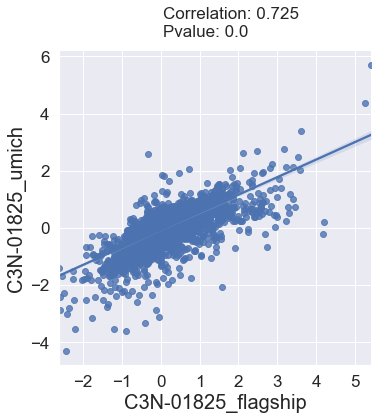

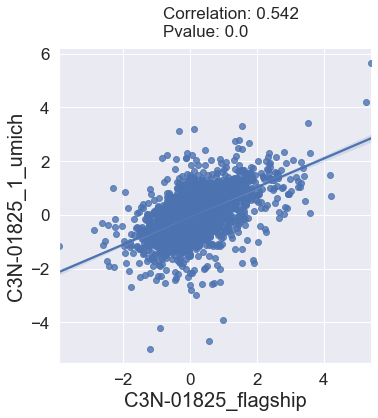

In [37]:
print(omics)
for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

wrap_lin_reg(both, dup_list, y_lab = 'umich')

In [23]:
print(omics)
get_corr(both, dup_list)

phospho


,Comparison,Correlation,P_value
0,C3N-01825,0.769300,0.0
0,C3N-01825_1,0.450708,0.0
